<a href="https://colab.research.google.com/github/shreyas-sreedhar/gen-ai-csye7380/blob/main/Assignment-04/Assignment04_Shreyas_S_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p '/content/drive/MyDrive/GenAI_2/images'

In [3]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# We'll start by rewriting the architecture for both the generator and discriminator networks
# using convolutional layers and adjusting the code to work with the CIFAR-10 dataset.

class GAN:
    def __init__(self):
        # Input shape for CIFAR-10 images (32x32x3)
        self.img_shape = (32, 32, 3)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model, we only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # Combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=200):
        # Load CIFAR-10 data and use one class (e.g., 'deer', class 4)
        (X_train, y_train), (_, _) = cifar10.load_data()
        X_train = X_train[y_train.flatten() == 4]

        # Rescale images from [0,255] to [-1,1]
        X_train = X_train / 127.5 - 1.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            # Print the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

            # Save generated image samples at save_interval
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"/content/drive/MyDrive/GenAI_2/images/cifar10_{epoch}.png")
        plt.show()
        plt.close()


In [7]:

if __name__ == '__main__':
    gan = GAN()

    gan.train(epochs=100, batch_size=32, save_interval=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
0 [D loss: 0.679500937461853, acc.: 68.75%] [G loss: [array(0.68397176, dtype=float32), array(0.68397176, dtype=float32), array(0.65625, dtype=float32)]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1 [D loss: 0.6897320747375488, acc.: 52.34375%] [G loss: [array(0.69110703, dtype=float32), array(0.69110703, dtype=float32), array(0.453125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2 [D loss: 0.6920084953308105, acc.: 44.68750059604645%] [G loss: [array(0.6935706, dtype=float32), array(0.6935706, dtype=float32), array(0.40625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
3 [D loss: 0.6934541463851929, acc.: 41.43415093421936%] [G loss: [array(0.69519395, dtype=float32), array(0.69519395, dtype=float32), array(0.38671875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
4 [D loss: 0.6956453323364258, acc.: 39.91319537162781%] [G loss: [array(0.69778425, dtype=float32), array(0.69778425, dtype=float32), array(0.378125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
5 [D loss: 0.6986672878265381, acc.: 38.11553120613098%] [G loss: [array(0.70104617, dtype=float32), arr

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7217608690261841, acc.: 34.375%] [G loss: [array(0.71208644, dtype=float32), array(0.71208644, dtype=float32), array(0.4375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


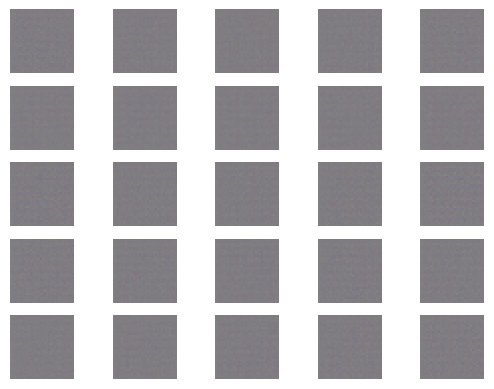

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1 [D loss: 0.7132239937782288, acc.: 33.46354365348816%] [G loss: [array(0.71074927, dtype=float32), array(0.71074927, dtype=float32), array(0.3046875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2 [D loss: 0.7127141952514648, acc.: 28.64583432674408%] [G loss: [array(0.71167314, dtype=float32), array(0.71167314, dtype=float32), array(0.2604167, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3 [D loss: 0.7130907773971558, acc.: 23.85602742433548%] [G loss: [array(0.7127889, dtype=float32), array(0.7127889, dtype=float32), array(0.22265625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4 [D loss: 0.7147244215011597, acc.: 20.12152671813965%] [G loss: [array(0.7148752, dtype=float32), array(0.7148752, dtype=float32), array(0.190625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5 [D loss: 0.7174279689788818, acc.: 18.241004645824432%] [G loss: [array(0.71807355, dtype=float32), array(0.71807355, dtype=float32), array(0.17447917, dtype=float32)]]
1/1 ━

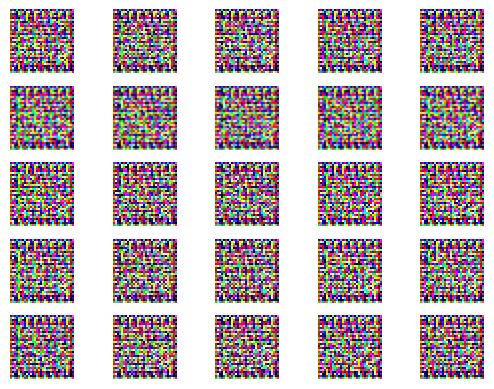

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
201 [D loss: 1.732344388961792, acc.: 10.587067157030106%] [G loss: [array(1.7350005, dtype=float32), array(1.7350005, dtype=float32), array(0.10573948, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
202 [D loss: 1.7352125644683838, acc.: 10.604208707809448%] [G loss: [array(1.737915, dtype=float32), array(1.737915, dtype=float32), array(0.10591133, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
203 [D loss: 1.7381172180175781, acc.: 10.582838207483292%] [G loss: [array(1.7407787, dtype=float32), array(1.7407787, dtype=float32), array(0.10569853, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
204 [D loss: 1.7409517765045166, acc.: 10.584570467472076%] [G loss: [array(1.7436124, dtype=float32), array(1.7436124, dtype=float32), array(0.10571647, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
205 [D loss: 1.7437961101531982, acc.: 10.601473599672318%] [G loss: [array(1.7464445, dtype=float32), array(1.7464445, dtype=flo

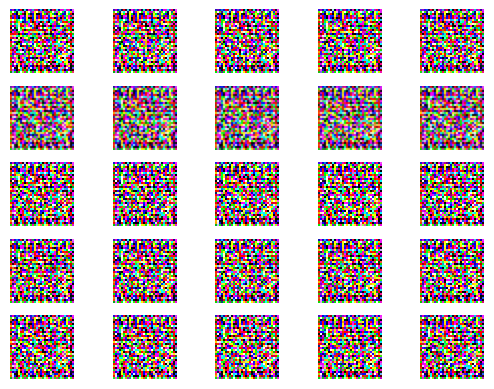

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
401 [D loss: 2.1270947456359863, acc.: 10.699288547039032%] [G loss: [array(2.1286697, dtype=float32), array(2.1286697, dtype=float32), array(0.10692631, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
402 [D loss: 2.1284985542297363, acc.: 10.703758895397186%] [G loss: [array(2.1300848, dtype=float32), array(2.1300848, dtype=float32), array(0.10697115, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
403 [D loss: 2.1299352645874023, acc.: 10.704338550567627%] [G loss: [array(2.1315129, dtype=float32), array(2.1315129, dtype=float32), array(0.10697711, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
404 [D loss: 2.1313657760620117, acc.: 10.712635517120361%] [G loss: [array(2.1329522, dtype=float32), array(2.1329522, dtype=float32), array(0.10706019, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
405 [D loss: 2.1327877044677734, acc.: 10.724741965532303%] [G loss: [array(2.1343544, dtype=float32), array(2.1343544, dtype=

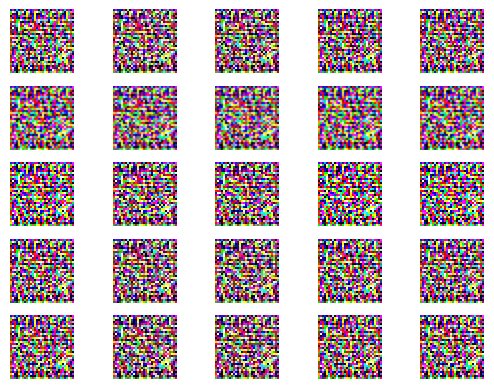

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
601 [D loss: 2.3508682250976562, acc.: 10.801829397678375%] [G loss: [array(2.3519876, dtype=float32), array(2.3519876, dtype=float32), array(0.10797342, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
602 [D loss: 2.351743221282959, acc.: 10.807240009307861%] [G loss: [array(2.3528554, dtype=float32), array(2.3528554, dtype=float32), array(0.10802757, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
603 [D loss: 2.3526296615600586, acc.: 10.815219581127167%] [G loss: [array(2.35376, dtype=float32), array(2.35376, dtype=float32), array(0.10810741, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
604 [D loss: 2.3535375595092773, acc.: 10.81283837556839%] [G loss: [array(2.3546576, dtype=float32), array(2.3546576, dtype=float32), array(0.10808368, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
605 [D loss: 2.354435682296753, acc.: 10.81046462059021%] [G loss: [array(2.355556, dtype=float32), array(2.355556, dtype=float32), 

KeyboardInterrupt: 

In [5]:

if __name__ == '__main__':
    gan = GAN()

    gan.train(epochs=1001, batch_size=32, save_interval=200)

In [6]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used!")
    print("GPU Info:", tf.config.list_physical_devices('GPU'))
else:
    print("No GPU detected. Make sure GPU is enabled in Colab.")


GPU is available and being used!
GPU Info: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# We'll start by rewriting the architecture for both the generator and discriminator networks
# using convolutional layers and adjusting the code to work with the CIFAR-10 dataset.

class GAN_a:
    def __init__(self):
        self.img_shape = (32, 32, 3)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))  # Batch Normalization added
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))  # Batch Normalization added
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization(momentum=0.8))  # Batch Normalization added
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))  # Batch Normalization added
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)


    def train(self, epochs, batch_size=128, save_interval=200):
        # Load CIFAR-10 data and use one class (e.g., 'deer', class 4)
        (X_train, y_train), (_, _) = cifar10.load_data()
        X_train = X_train[y_train.flatten() == 4]

        # Rescale images from [0,255] to [-1,1]
        X_train = X_train / 127.5 - 1.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            # Print the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

            # Save generated image samples at save_interval
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"/content/drive/MyDrive/GenAI_2/images/cifar10_{epoch}.png")
        plt.show()
        plt.close()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6579306125640869, acc.: 64.84375%] [G loss: [array(0.6702517, dtype=float32), array(0.6702517, dtype=float32), array(0.484375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


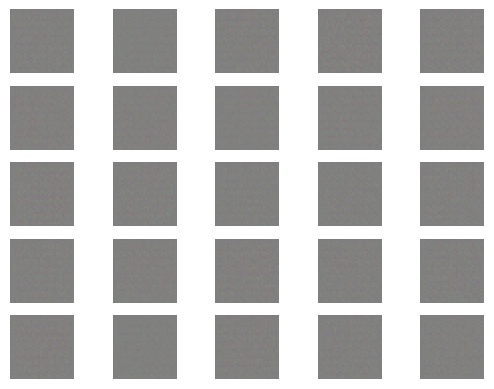

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1 [D loss: 0.6663857698440552, acc.: 54.6875%] [G loss: [array(0.67095345, dtype=float32), array(0.67095345, dtype=float32), array(0.46875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2 [D loss: 0.6688665151596069, acc.: 50.98958611488342%] [G loss: [array(0.6719746, dtype=float32), array(0.6719746, dtype=float32), array(0.4635417, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3 [D loss: 0.6718895435333252, acc.: 48.13058078289032%] [G loss: [array(0.674531, dtype=float32), array(0.674531, dtype=float32), array(0.44921875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4 [D loss: 0.672713041305542, acc.: 47.82986044883728%] [G loss: [array(0.6752087, dtype=float32), array(0.6752087, dtype=float32), array(0.453125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5 [D loss: 0.6749204993247986, acc.: 46.82765305042267%] [G loss: [array(0.67743397, dtype=float32), array(0.67743397, dtype=float32), array(0.4479167, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━

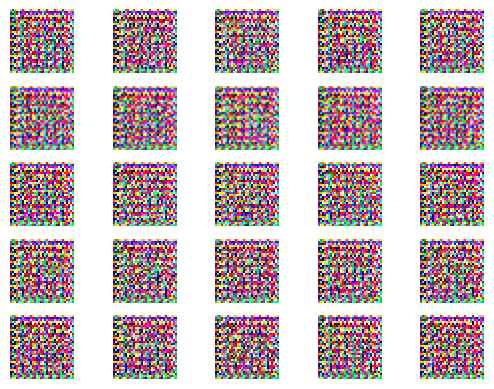

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
101 [D loss: 1.377720832824707, acc.: 44.28773820400238%] [G loss: [array(1.3822782, dtype=float32), array(1.3822782, dtype=float32), array(0.44178924, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
102 [D loss: 1.383091926574707, acc.: 44.31291222572327%] [G loss: [array(1.3875475, dtype=float32), array(1.3875475, dtype=float32), array(0.44205096, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
103 [D loss: 1.3883938789367676, acc.: 44.35266852378845%] [G loss: [array(1.3928114, dtype=float32), array(1.3928114, dtype=float32), array(0.44245794, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
104 [D loss: 1.393632173538208, acc.: 44.317078590393066%] [G loss: [array(1.3980689, dtype=float32), array(1.3980689, dtype=float32), array(0.4421131, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
105 [D loss: 1.3990647792816162, acc.: 44.3264901638031%] [G loss: [array(1.4036129, dtype=float32), array(1.4036129, dtype=float32),

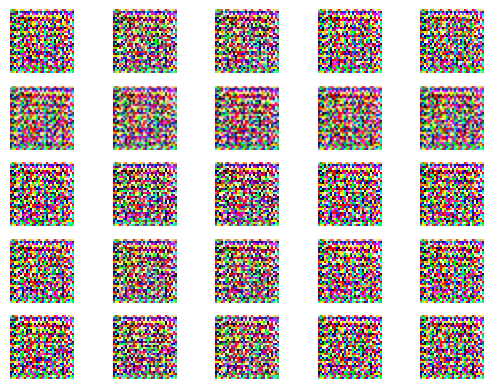

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
201 [D loss: 1.7805148363113403, acc.: 44.40062642097473%] [G loss: [array(1.7834693, dtype=float32), array(1.7834693, dtype=float32), array(0.44345605, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
202 [D loss: 1.783609390258789, acc.: 44.405123591423035%] [G loss: [array(1.7865664, dtype=float32), array(1.7865664, dtype=float32), array(0.44350368, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
203 [D loss: 1.7866014242172241, acc.: 44.4249153137207%] [G loss: [array(1.7894856, dtype=float32), array(1.7894856, dtype=float32), array(0.44370407, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
204 [D loss: 1.789671540260315, acc.: 44.429248571395874%] [G loss: [array(1.7926375, dtype=float32), array(1.7926375, dtype=float32), array(0.44375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
205 [D loss: 1.792691946029663, acc.: 44.44113373756409%] [G loss: [array(1.7955649, dtype=float32), array(1.7955649, dtype=float32), 

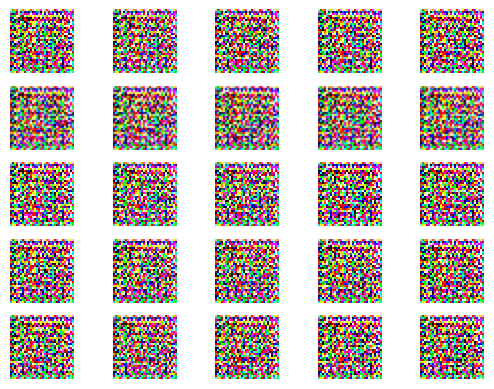

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
301 [D loss: 2.027228593826294, acc.: 44.37658190727234%] [G loss: [array(2.0293648, dtype=float32), array(2.0293648, dtype=float32), array(0.44339818, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
302 [D loss: 2.0292468070983887, acc.: 44.37451362609863%] [G loss: [array(2.0314045, dtype=float32), array(2.0314045, dtype=float32), array(0.44337872, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
303 [D loss: 2.031243324279785, acc.: 44.377601146698%] [G loss: [array(2.0333548, dtype=float32), array(2.0333548, dtype=float32), array(0.44341078, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
304 [D loss: 2.033207893371582, acc.: 44.3652868270874%] [G loss: [array(2.0353434, dtype=float32), array(2.0353434, dtype=float32), array(0.44328892, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
305 [D loss: 2.0351991653442383, acc.: 44.3786084651947%] [G loss: [array(2.0373588, dtype=float32), array(2.0373588, dtype=float32), ar

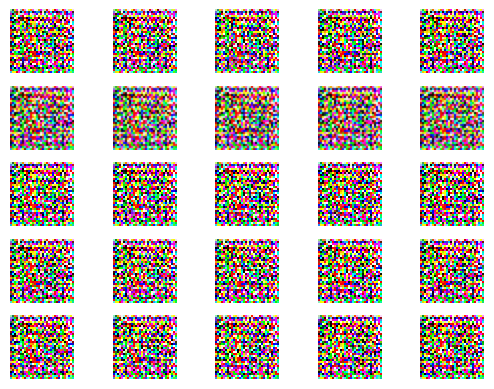

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
401 [D loss: 2.2006354331970215, acc.: 44.2711740732193%] [G loss: [array(2.2023308, dtype=float32), array(2.2023308, dtype=float32), array(0.44243625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
402 [D loss: 2.2021021842956543, acc.: 44.269877672195435%] [G loss: [array(2.203815, dtype=float32), array(2.203815, dtype=float32), array(0.442424, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
403 [D loss: 2.2035927772521973, acc.: 44.26472187042236%] [G loss: [array(2.2053006, dtype=float32), array(2.2053006, dtype=float32), array(0.44237313, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
404 [D loss: 2.20504093170166, acc.: 44.275033473968506%] [G loss: [array(2.2067263, dtype=float32), array(2.2067263, dtype=float32), array(0.44247687, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
405 [D loss: 2.206468105316162, acc.: 44.28529143333435%] [G loss: [array(2.208155, dtype=float32), array(2.208155, dtype=float32), arr

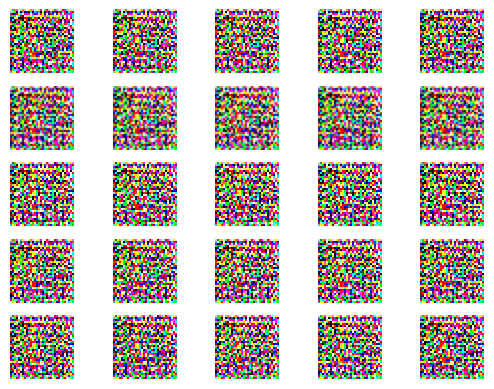

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
501 [D loss: 2.332545757293701, acc.: 44.1828727722168%] [G loss: [array(2.3339863, dtype=float32), array(2.3339863, dtype=float32), array(0.44160858, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
502 [D loss: 2.3337368965148926, acc.: 44.17579770088196%] [G loss: [array(2.3351574, dtype=float32), array(2.3351574, dtype=float32), array(0.4415383, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
503 [D loss: 2.3348870277404785, acc.: 44.16564404964447%] [G loss: [array(2.3362894, dtype=float32), array(2.3362894, dtype=float32), array(0.44143727, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
504 [D loss: 2.336024045944214, acc.: 44.16482150554657%] [G loss: [array(2.3374383, dtype=float32), array(2.3374383, dtype=float32), array(0.44142947, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
505 [D loss: 2.3371920585632324, acc.: 44.15163993835449%] [G loss: [array(2.3386226, dtype=float32), array(2.3386226, dtype=float32),

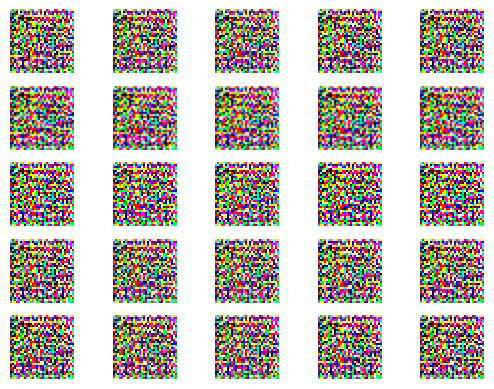

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
601 [D loss: 2.437943458557129, acc.: 44.19402480125427%] [G loss: [array(2.439147, dtype=float32), array(2.439147, dtype=float32), array(0.44175664, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
602 [D loss: 2.4388604164123535, acc.: 44.201064109802246%] [G loss: [array(2.4400697, dtype=float32), array(2.4400697, dtype=float32), array(0.44182733, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
603 [D loss: 2.4397923946380615, acc.: 44.200319051742554%] [G loss: [array(2.441004, dtype=float32), array(2.441004, dtype=float32), array(0.44182014, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
604 [D loss: 2.4407477378845215, acc.: 44.194406270980835%] [G loss: [array(2.441974, dtype=float32), array(2.441974, dtype=float32), array(0.44176137, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
605 [D loss: 2.441704034805298, acc.: 44.19625401496887%] [G loss: [array(2.4429302, dtype=float32), array(2.4429302, dtype=float32), 

In [ ]:

if __name__ == '__main__':
    gan = GAN_a()

    gan.train(epochs=700, batch_size=32, save_interval=100)

In [1]:
# We'll start by rewriting the architecture for both the generator and discriminator networks
# using convolutional layers and adjusting the code to work with the CIFAR-10 dataset.

class GAN_noise_1:
    def __init__(self):
        # Input shape for CIFAR-10 images (32x32x3)
        self.img_shape = (32, 32, 3)
        self.latent_dim = 1

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model, we only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # Combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=200):
        # Load CIFAR-10 data and use one class (e.g., 'deer', class 4)
        (X_train, y_train), (_, _) = cifar10.load_data()
        X_train = X_train[y_train.flatten() == 4]

        # Rescale images from [0,255] to [-1,1]
        X_train = X_train / 127.5 - 1.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)

            # Print the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

            # Save generated image samples at save_interval
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"/content/drive/MyDrive/GenAI_2/images/cifar10_{epoch}.png")
        plt.show()
        plt.close()


In [2]:
# We'll start by rewriting the architecture for both the generator and discriminator networks
# using convolutional layers and adjusting the code to work with the CIFAR-10 dataset.

class GAN_noise_2:
    def __init__(self):
        # Input shape for CIFAR-10 images (32x32x3)
        self.img_shape = (32, 32, 3)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model, we only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # Combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=200):
        # Load CIFAR-10 data and use one class (e.g., 'deer', class 4)
        (X_train, y_train), (_, _) = cifar10.load_data()
        X_train = X_train[y_train.flatten() == 4]

        # Rescale images from [0,255] to [-1,1]
        X_train = X_train / 127.5 - 1.0

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)

            # Print the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

            # Save generated image samples at save_interval
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"/content/drive/MyDrive/GenAI_2/images_10n/cifar10_{epoch}.png")
        plt.show()
        plt.close()


In [3]:
if __name__ == '__main__':
    gan = GAN_noise_2()

    gan.train(epochs=500, batch_size=32, save_interval=100)

NameError: name 'Adam' is not defined